In [1]:
# Importing all the necessary libraries
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import pickle

2024-11-22 21:32:58.502257: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-22 21:32:58.550715: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-22 21:32:59.322184: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Stopwords for english and hindi language

nltk.download('stopwords')
english_stopwords = stopwords.words('english')
hindi_stop_word_file = open("hindi_stopwords.txt")
hindi_stopwords = hindi_stop_word_file.read()
hindi_stopwords = list(hindi_stopwords.split("\n"))
hindi_stop_word_file.close()

[nltk_data] Downloading package stopwords to /home/user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Listing categories, subcategories, and missing subcategories in the training dataset.
# Creating a index map for categories and subcategories.
categories_list = [
       'Online and Social Media Related Crime', 'Online Financial Fraud',
       'Online Gambling  Betting',
       'RapeGang Rape RGRSexually Abusive Content',
       'Any Other Cyber Crime', 'Cyber Attack/ Dependent Crimes',
       'Cryptocurrency Crime', 'Sexually Explicit Act',
       'Sexually Obscene material',
       'Hacking  Damage to computercomputer system etc',
       'Cyber Terrorism',
       'Child Pornography CPChild Sexual Abuse Material CSAM',
       'Online Cyber Trafficking', 'Ransomware',
       'Report Unlawful Content'
]

sub_categories = [
            'Cyber Bullying  Stalking  Sexting', 'Fraud CallVishing',
           'Online Gambling  Betting', 'Online Job Fraud',
           'UPI Related Frauds', 'Internet Banking Related Fraud',
           'Other', 'Profile Hacking Identity Theft',
           'DebitCredit Card FraudSim Swap Fraud', 'EWallet Related Fraud',
           'Data Breach/Theft', 'Cheating by Impersonation',
           'Denial of Service (DoS)/Distributed Denial of Service (DDOS) attacks',
           'FakeImpersonating Profile', 'Cryptocurrency Fraud',
           'Malware Attack', 'Business Email CompromiseEmail Takeover',
           'Email Hacking', 'Hacking/Defacement',
           'Unauthorised AccessData Breach', 'SQL Injection',
           'Provocative Speech for unlawful acts', 'Ransomware Attack',
           'Cyber Terrorism', 'Tampering with computer source documents',
           'DematDepository Fraud', 'Online Trafficking',
           'Online Matrimonial Fraud', 'Website DefacementHacking',
           'Damage to computer computer systems etc', 'Impersonating Email',
           'EMail Phishing', 'Ransomware', 'Intimidating Email',
           'Against Interest of sovereignty or integrity of India'
    ]
additonal_subcat = [
        'Sexually Explicit Act',
        'Sexually Obscene material',
        'Child Pornography CPChild Sexual Abuse Material CSAM',
        'RapeGang Rape RGRSexually Abusive Content'
    ]


subcategory_list = sub_categories
subcategory_list.extend(additonal_subcat)
subcat_index_map = dict(
        zip(
            subcategory_list,
            range(len(subcategory_list))
        )
    )

cat_index_map = dict(
    zip(
        categories_list,
        range(len(categories_list))
        
    )
)

In [4]:
# Data preparation : Dropping duplicate training and testing data with respect to crimeaditionalinfo column.
# Removing rows with blank crimeaditionalinfo value.
# Filling missing subcategories with categories
# Ensure all text data is in string format

def get_info_and_labels(fpath : str):
    df = pd.read_csv(fpath)
    print(f"[*] Total Number of samples :: {df.shape[0]}")
    df = df.drop_duplicates(['crimeaditionalinfo'])
    df = df[df['crimeaditionalinfo'].notnull()]
    print(f"[*] Number of samples after removing empty, duplicate *Crime Additional Info*  :: {df.shape[0]}")

    x, y_category, y_subcategory = [], [], []
    for sub_cat in sub_categories:
        sub_cat_df = df.query(f"sub_category == '{sub_cat}'")
        x_content = sub_cat_df['crimeaditionalinfo'].values
        y_sub_cat_values = sub_cat_df['sub_category'].values
        y_cat_values = sub_cat_df['category'].values
        x.extend(x_content)
        y_subcategory.extend(y_sub_cat_values)
        y_category.extend(y_cat_values)
        
        
    for sub_cat in additonal_subcat:
        sub_cat_df = df.query(f"category == '{sub_cat}'")
        x_content = sub_cat_df['crimeaditionalinfo'].values
        y_sub_cat_values = sub_cat_df['category'].values
        y_cat_values = sub_cat_df['category'].values
        x.extend(x_content)
        y_subcategory.extend(y_sub_cat_values)
        y_category.extend(y_cat_values)

    return x, y_category, y_subcategory

In [5]:
# Preparing string datasets for train and test

x_train, y_train_cat, y_train_subcat = get_info_and_labels("./TrainingData/training_dataset.csv")
x_test, y_test_cat, y_test_subcat = get_info_and_labels("./TrainingData/testing_dataset.csv")

[*] Total Number of samples :: 93686
[*] Number of samples after removing empty, duplicate *Crime Additional Info*  :: 85013
[*] Total Number of samples :: 31229
[*] Number of samples after removing empty, duplicate *Crime Additional Info*  :: 28785


In [6]:
# Text pre-processing : Lowercase the strings.
# Removing certain escape characters.
# Removing all characters other than lowercase alphabets(a-z).
# Removing extra white spaces between words.
# Removing stopwords from the strings.
# Note : Additional complex pre-processing like lemmatization, stemming and other standard techniques on english dataset is not applied because of Hinglish words being present in the dataset which causes unforeseen results

def filter_fxn(x):
    if x == '' or len(x) <= 2 or len(x) > 15:
        return False
    if (x in english_stopwords) or (x in hindi_stopwords):
        return False
    return True


def transform_text(text):
    text = text.lower()
    valid_char = "abcdefghijklmnopqrstuvwxyz" + " "
    escape_char_list = ["\r", "\n", "\b", "\t"]
    for escape_char in escape_char_list:
        text = text.replace(escape_char, " ")
        
    for c in text:
        if c not in valid_char:
            text = text.replace(c, "")
    text_list = text.split(" ")            
    text_list = list(filter(filter_fxn, text_list))
    return " ".join(text_list)

x_train = list(map(transform_text, x_train))
x_test = list(map(transform_text, x_test))

In [7]:
# Preparing appropriate labels for categories and subcategories, for train and test data.

y_train_cat_labels = []
y_train_subcat_labels = []

y_test_cat_labels = []
y_test_subcat_labels = []

for sub_cat in y_train_subcat:
    y_train_subcat_labels.append(subcat_index_map[sub_cat])
for cat in y_train_cat:
    y_train_cat_labels.append(cat_index_map[cat])


for sub_cat in y_test_subcat:
    y_test_subcat_labels.append(subcat_index_map[sub_cat])
    
for cat in y_test_cat:
    y_test_cat_labels.append(cat_index_map[cat])


y_train_cat = tf.keras.utils.to_categorical(y_train_cat_labels, num_classes = len(cat_index_map))# labels
y_train_subcat = tf.keras.utils.to_categorical(y_train_subcat_labels, num_classes = len(subcat_index_map))   

y_test_cat = tf.keras.utils.to_categorical(y_test_cat_labels, num_classes = len(cat_index_map))# labels
y_test_subcat = tf.keras.utils.to_categorical(y_test_subcat_labels, num_classes = len(subcat_index_map)) 

In [8]:
# Creating Bag-of-words corpus vectors for pre-processing
# Transforming the train and test data to text vectors based on bag-of-words approach.

text_vectorization = tf.keras.layers.TextVectorization(
    max_tokens = 10000,
    output_mode = 'multi_hot',
    ngrams = 2,
    pad_to_max_tokens=True
    
)
text_vectorization.adapt(x_train)

pickle.dump({'config': text_vectorization.get_config(),
             'weights': text_vectorization.get_weights()}
            , open("text_vector.pkl", "wb"))

x_train = text_vectorization(x_train)
x_test = text_vectorization(x_test)

2024-11-22 21:34:13.147934: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30925 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:89:00.0, compute capability: 7.0


In [9]:
# Building deep learning model architecture from scratch.
# Architecture contains 1 Input layer, 1 hidden layer, 2 classification heads(for category and subcategory classification each)
# Lr schedular was used for dynamic learning rate.
# Adam optimizer is used

inputs = tf.keras.Input(shape = (x_train.shape[1]), name = 'input_seq')
output = Dense(1024, input_dim=x_train.shape[1], activation='relu', kernel_regularizer = tf.keras.regularizers.l2(0.2))(inputs)
cat_output = Dense(y_train_cat.shape[1], activation = 'softmax', name = 'cat_output')(output)
subcat_output = Dense(y_train_subcat.shape[1], activation = 'softmax', name = 'sub_cat_output')(output)
model = tf.keras.models.Model(inputs, [cat_output, subcat_output])

lr_schedule =tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=4000,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(
    optimizer=optimizer,
    loss = {
        'cat_output': "categorical_crossentropy",
        'sub_cat_output': "categorical_crossentropy"
    },
    metrics = {
        'cat_output': ["acc"],
        'sub_cat_output': ["acc"]
    }
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_seq (InputLayer)         [(None, 10000)]      0           []                               
                                                                                                  
 dense (Dense)                  (None, 1024)         10241024    ['input_seq[0][0]']              
                                                                                                  
 cat_output (Dense)             (None, 15)           15375       ['dense[0][0]']                  
                                                                                                  
 sub_cat_output (Dense)         (None, 39)           39975       ['dense[0][0]']                  
                                                                                              

In [10]:
# Creating proper dataloader

def format_datset(x_seq, y_cat, y_subcat):
    return (
        x_seq,
        {
            "cat_output": y_cat,
            "sub_cat_output": y_subcat
        }
    )


train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train_cat, y_train_subcat)).batch(32).shuffle(2028)
train_dataset = train_dataset.map(format_datset)


test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test_cat, y_test_subcat)).batch(32).shuffle(2028)
test_dataset = test_dataset.map(format_datset)

In [11]:
# Creating checkpoint callback.
# Training the model on train dataset while validating on test dataset.
# Evaluating model on test dataset

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "CrimeReportTextClassification.keras",
        save_best_only = True,
    )
    
]
history = model.fit(train_dataset, epochs=100, validation_data=test_dataset, callbacks = callbacks,verbose=1)
accuracy = model.evaluate(test_dataset)

Epoch 1/100


2024-11-22 21:34:26.847736: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [85013,10000]
	 [[{{node Placeholder/_0}}]]
2024-11-22 21:34:26.848032: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [85013,39]
	 [[{{node Placeholder/_2}}]]
2024-11-22 21:34:29.213820: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7eefe01014c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-22 21:34:29.213847: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): Tes

2645/2657 [============================>.] - ETA: 0s - loss: 5.5375 - cat_output_loss: 1.0350 - sub_cat_output_loss: 2.2427 - cat_output_acc: 0.6729 - sub_cat_output_acc: 0.3406

2024-11-22 21:34:38.504619: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [28781,39]
	 [[{{node Placeholder/_2}}]]
2024-11-22 21:34:38.504895: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [28781,15]
	 [[{{node Placeholder/_1}}]]


2657/2657 [==============================] - 15s 4ms/step - loss: 5.5364 - cat_output_loss: 1.0367 - sub_cat_output_loss: 2.2430 - cat_output_acc: 0.6727 - sub_cat_output_acc: 0.3408 - val_loss: 4.4562 - val_cat_output_loss: 0.9447 - val_sub_cat_output_loss: 2.1453 - val_cat_output_acc: 0.7105 - val_sub_cat_output_acc: 0.3260
Epoch 2/100
2657/2657 [==============================] - 12s 4ms/step - loss: 4.1278 - cat_output_loss: 0.9428 - sub_cat_output_loss: 2.0554 - cat_output_acc: 0.6976 - sub_cat_output_acc: 0.3817 - val_loss: 3.9235 - val_cat_output_loss: 0.9513 - val_sub_cat_output_loss: 2.0341 - val_cat_output_acc: 0.6896 - val_sub_cat_output_acc: 0.4081
Epoch 3/100
2657/2657 [==============================] - 12s 4ms/step - loss: 3.9391 - cat_output_loss: 0.9182 - sub_cat_output_loss: 1.9918 - cat_output_acc: 0.7031 - sub_cat_output_acc: 0.3975 - val_loss: 3.7330 - val_cat_output_loss: 0.9534 - val_sub_cat_output_loss: 2.0044 - val_cat_output_acc: 0.6723 - val_sub_cat_output_acc:

In [9]:
model = tf.keras.models.load_model("CrimeReportTextClassification.keras")

In [12]:
# Evaluating accuracy score, precision score, recall score, f1 score for both category and subcategory classification.

pred_cat, pred_subcat = model.predict(format_datset(x_test, y_test_cat, y_test_subcat)[0])

print("Category classification Accuracy: ", accuracy_score(np.argmax(y_test_cat, axis = 1), np.argmax(pred_cat, axis = 1)))
print("Category classification Precision: ", precision_score(np.argmax(y_test_cat, axis = 1), np.argmax(pred_cat, axis = 1), average="micro"))
print("Category classification Recall: ", recall_score(np.argmax(y_test_cat, axis = 1), np.argmax(pred_cat, axis = 1), average="micro"))
print("Category classification F1-score: ", f1_score(np.argmax(y_test_cat, axis = 1), np.argmax(pred_cat, axis = 1), average="micro"))
print()
print("Subcategory classification Accuracy: ", accuracy_score(np.argmax(y_test_subcat, axis = 1), np.argmax(pred_subcat, axis = 1)))
print("Subcategory classification Precision: ", precision_score(np.argmax(y_test_subcat, axis = 1), np.argmax(pred_subcat, axis = 1), average="micro"))
print("Subcategory classification Recall: ", recall_score(np.argmax(y_test_subcat, axis = 1), np.argmax(pred_subcat, axis = 1), average="micro"))
print("Subcategory classification F1-score", f1_score(np.argmax(y_test_subcat, axis = 1), np.argmax(pred_subcat, axis = 1), average="micro"))

900/900 [==============================] - 1s 1ms/step
Category classification Accuracy:  0.7275285778812411
Category classification Precision:  0.7275285778812411
Category classification Recall:  0.7275285778812411
Category classification F1-score:  0.7275285778812413

Subcategory classification Accuracy:  0.5044300059066745
Subcategory classification Precision:  0.5044300059066745
Subcategory classification Recall:  0.5044300059066745
Subcategory classification F1-score 0.5044300059066745


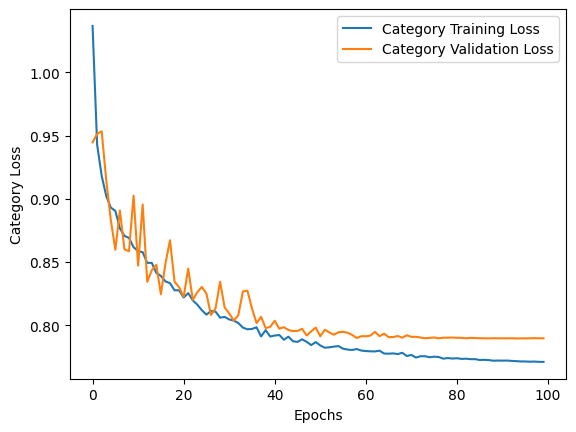

In [13]:
plt.plot(history.history['cat_output_loss'], label='Category Training Loss')
plt.plot(history.history['val_cat_output_loss'], label='Category Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Category Loss')
plt.legend()

plt.show()

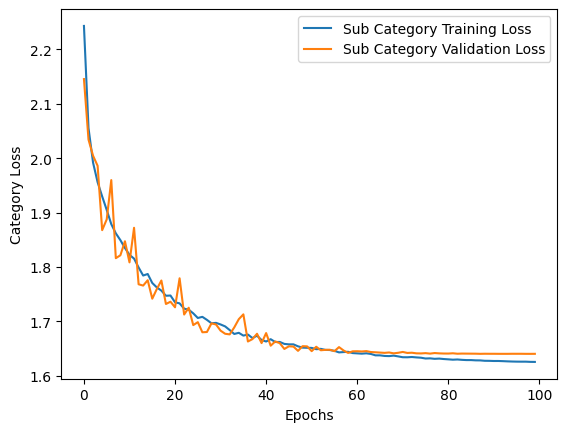

In [14]:
plt.plot(history.history['sub_cat_output_loss'], label='Sub Category Training Loss')
plt.plot(history.history['val_sub_cat_output_loss'], label='Sub Category Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Category Loss')
plt.legend()

plt.show()

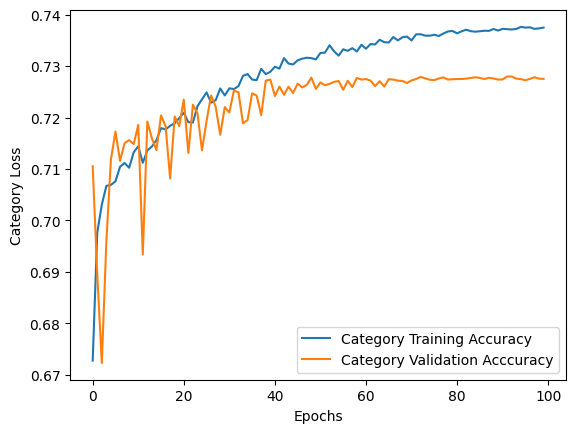

In [15]:
plt.plot(history.history['cat_output_acc'], label='Category Training Accuracy')
plt.plot(history.history['val_cat_output_acc'], label='Category Validation Acccuracy')
plt.xlabel('Epochs')
plt.ylabel('Category Loss')
plt.legend()

plt.show()

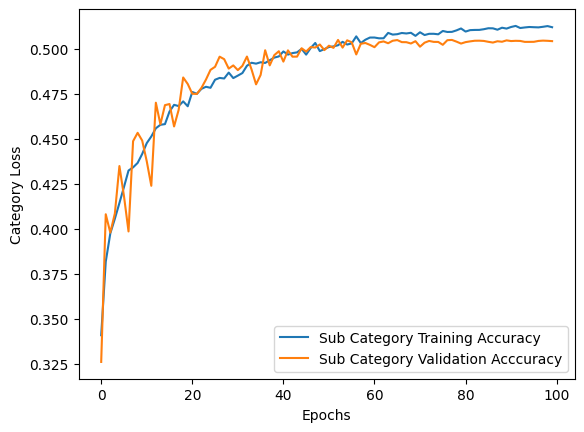

In [16]:
plt.plot(history.history['sub_cat_output_acc'], label='Sub Category Training Accuracy')
plt.plot(history.history['val_sub_cat_output_acc'], label='Sub Category Validation Acccuracy')
plt.xlabel('Epochs')
plt.ylabel('Category Loss')
plt.legend()

plt.show()